# Esse DataSet foi adquirido de uma competição do Kaggle chamada: `Multi-Class Prediction of Obesity Risk`, pode ser acessada nesse link:
##[Kaggle-ObesityRisk](https://www.kaggle.com/competitions/playground-series-s4e2)

#**Descrição do Conjunto de Dados**
##O conjunto de dados para esta competição (tanto de treino quanto de teste) foi gerado a partir de um modelo de deep learning treinado no dataset de risco de Obesidade ou Doenças Cardiovasculares (CVD)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')


In [ ]:
X_train = df_train.drop(['id','NObeyesdad'], axis=1)
y_train = df_train['NObeyesdad']
X_test = df_test.drop(['id'], axis=1)


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV


In [ ]:
ohe = OneHotEncoder()
def ohe_df(df, cols):
    for col in cols:
      ohe.fit(df[col].values.reshape(-1,1))
      new_cols = ohe.transform(df[col].values.reshape(-1,1)).toarray()
      df[col] = new_cols




In [ ]:
for col in X_train.columns:
  if X_train[col].value_counts().shape[0] == 2:
    print(col)

Gender
family_history_with_overweight
FAVC
SMOKE
SCC


In [ ]:
cols_ohe = ['Gender','family_history_with_overweight','FAVC','SMOKE','SCC','MTRANS']
ohe_df(X_train,cols=cols_ohe)

In [ ]:
for col in X_train.columns:
  if X_train[col].dtype == 'float' and col not in cols_ohe :
    print(col)

Age
Height
Weight
FCVC
NCP
CH2O
FAF
TUE


In [ ]:
mms = MinMaxScaler()
def df_min_max_scaler(df, cols):
  for col in cols:
    df[col] = mms.fit_transform(df[col].values.reshape(-1,1))

In [ ]:
cols_mms = ['Age','Height','Weight','FCVC','NCP','CH2O','FAF','TUE']
df_min_max_scaler(X_train,cols=cols_mms)

In [ ]:
le = LabelEncoder()
def le_df(df, cols):
  for col in cols:
    df[col] = le.fit_transform(df[col])

In [ ]:
cols_le = ['CAEC','CALC',]
le_df(X_train,cols=cols_le)
y_train = le.fit_transform(y_train)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
from sklearn.model_selection import StratifiedKFold

xgb = XGBClassifier(learning_rate=0.1)

param_grid = {
 'n_estimators':range(0,500,25),
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=6, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))


Melhor: 0.9058967411085015 para {'n_estimators': 175}


In [ ]:
xgb = XGBClassifier(learning_rate=0.1,n_estimators=175)

param_grid = {
 'max_depth':range(3,6,1),
 'min_child_weight':range(1,3,1)
}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.9081454018917798 para {'max_depth': 5, 'min_child_weight': 1}


In [ ]:
xgb = XGBClassifier(learning_rate=0.1,n_estimators=175,max_depth=5,min_child_weight=1)
param_grid = {
 'gamma': [0,0.1,0.9],
 'colsample_bytree':[0.3,0.5]
}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))


Melhor: 0.9100071325616298 para {'colsample_bytree': 0.5, 'gamma': 0}


In [ ]:
xgb = XGBClassifier(n_estimators=175,max_depth=5,min_child_weight=1,colsample_bytree=0.5,gamma=0)

param_grid = {
    'learning_rate': [0.08,0.09,0.11]
}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))


Melhor: 0.9090434112136417 para {'learning_rate': 0.08}


In [ ]:
xgb = XGBClassifier(learning_rate=0.09, n_estimators=175, max_depth=5, min_child_weight=1, colsample_bytree=0.5, gamma=0)
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.95      0.93      0.94       640
           1       0.88      0.90      0.89       780
           2       0.89      0.87      0.88       685
           3       0.97      0.98      0.97       825
           4       1.00      1.00      1.00      1017
           5       0.80      0.79      0.80       611
           6       0.80      0.81      0.81       632

    accuracy                           0.91      5190
   macro avg       0.90      0.90      0.90      5190
weighted avg       0.91      0.91      0.91      5190



In [ ]:
class_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print(class_mapping)

{'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Obesity_Type_I': 2, 'Obesity_Type_II': 3, 'Obesity_Type_III': 4, 'Overweight_Level_I': 5, 'Overweight_Level_II': 6}


<ipython-input-168-b349e83d1bbd>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')


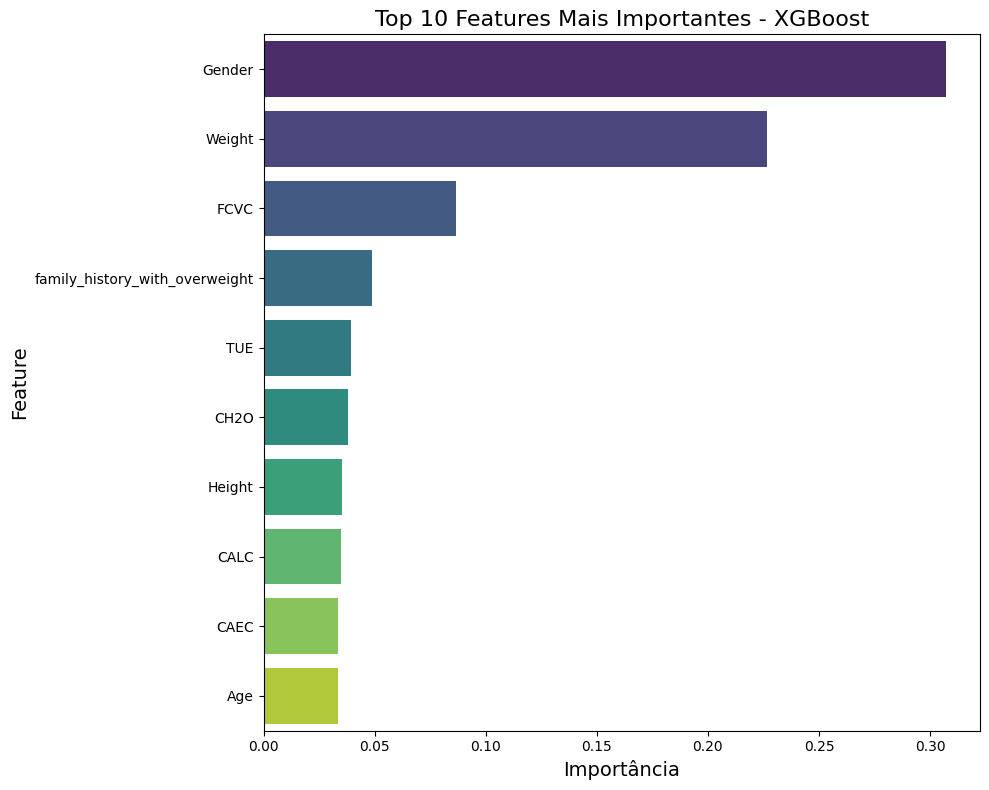

In [ ]:
feature_names = X_train.columns
importances = xgb.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Ordenar as features pela importância
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
top_n = 10

# Selecionar as top N features
top_features = feature_importance.head(top_n)

# Plotar
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title(f'Top {top_n} Features Mais Importantes - XGBoost', fontsize=16)
plt.xlabel('Importância', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
ohe_df(df_test,cols=cols_ohe)
df_min_max_scaler(df_test,cols=cols_mms)
le_df(df_test,cols=cols_le)
le_df(df_train,cols=['NObeyesdad'])

In [ ]:
id = df_test['id']
df_test = df_test.drop(['id'], axis=1)

In [ ]:
xgb.fit(X_train,y_train)
y_pred = xgb.predict(df_test)

In [ ]:
y_pred = le.inverse_transform(y_pred)


In [ ]:
pd.DataFrame({'id':id,'NObeyesdad':y_pred}).to_csv('submission.csv',index=False)

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
...,...,...
13835,34593,Overweight_Level_II
13836,34594,Normal_Weight
13837,34595,Insufficient_Weight
13838,34596,Normal_Weight


##Private Score: 0.88899

##Public Score: 0.89595
---


##TOP 1 Score: 0.91157

